In [1]:
!pip install numpy pandas matplotlib seaborn iminuit scikit-learn

Defaulting to user installation because normal site-packages is not writeable


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from iminuit import Minuit
# from sklearn.metrics import f1_score

In [2]:
detA = pd.read_csv("DetectorA.csv", header=None, names=["event_id", "class_score", "energy"])
detB = pd.read_csv("DetectorB.csv", header=None, names=["event_id", "class_score", "energy"])
detC = pd.read_csv("DetectorC.csv", header=None, names=["event_id", "class_score", "energy"])
print(detA)

       event_id  class_score    energy
0      734628.0        0.440  2123.514
1      229218.0        0.179  1017.985
2      428880.0        0.028  1862.961
3        1990.0        0.080  1619.836
4       55401.0        0.065  2611.720
...         ...          ...       ...
39995  920596.0        0.324  2278.508
39996  778459.0        0.209  2377.462
39997  484579.0        0.554  2612.247
39998  563791.0        0.018  1216.414
39999  729917.0        0.151  1944.577

[40000 rows x 3 columns]


Text(0, 0.5, 'Frequency')

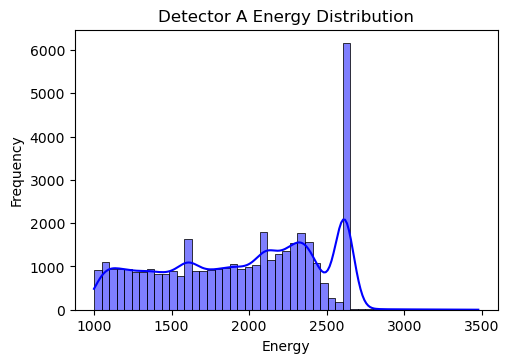

In [3]:
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
sns.histplot(detA['energy'], kde=True, color='blue')
plt.title('Detector A Energy Distribution')
plt.xlabel('Energy')
plt.ylabel('Frequency')

Text(0, 0.5, 'Class Score')

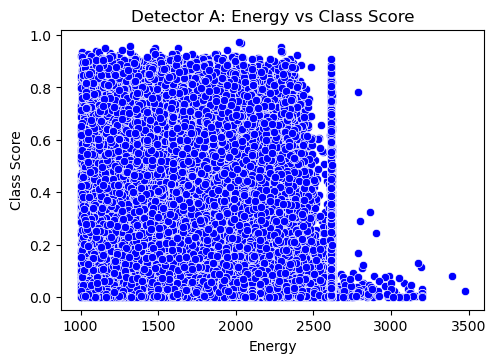

In [4]:

plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
sns.scatterplot(x='energy', y='class_score', data=detA, color='blue')
plt.title('Detector A: Energy vs Class Score')
plt.xlabel('Energy')
plt.ylabel('Class Score')

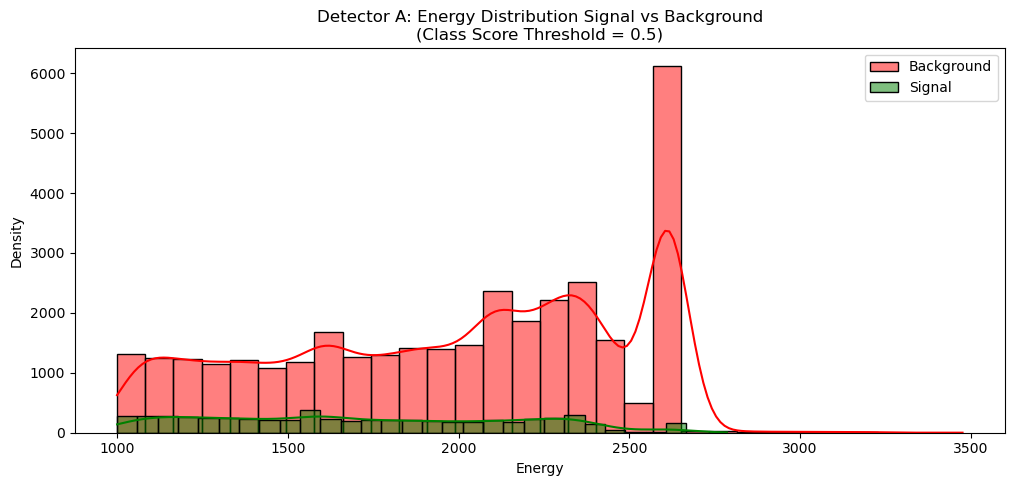

In [5]:
def split_plot(data, name, thresh=0.5, bins=30):
    detSignal = data[data['class_score'] > thresh]
    detBackground = data[data['class_score'] <= thresh]
    plt.figure(figsize=(12, 5))
    sns.histplot(detBackground['energy'], color='red', label='Background', kde=True, bins=bins)
    sns.histplot(detSignal['energy'], color='green', label='Signal', kde=True, bins=bins)
    plt.title(f'{name}: Energy Distribution Signal vs Background\n(Class Score Threshold = {thresh})')
    plt.xlabel('Energy')
    plt.ylabel('Density')
    plt.legend()
    plt.show()

split_plot(detA, 'Detector A', 0.5)

# 2a. Use 1592 keV peak in Detector A to set a cutting threshold


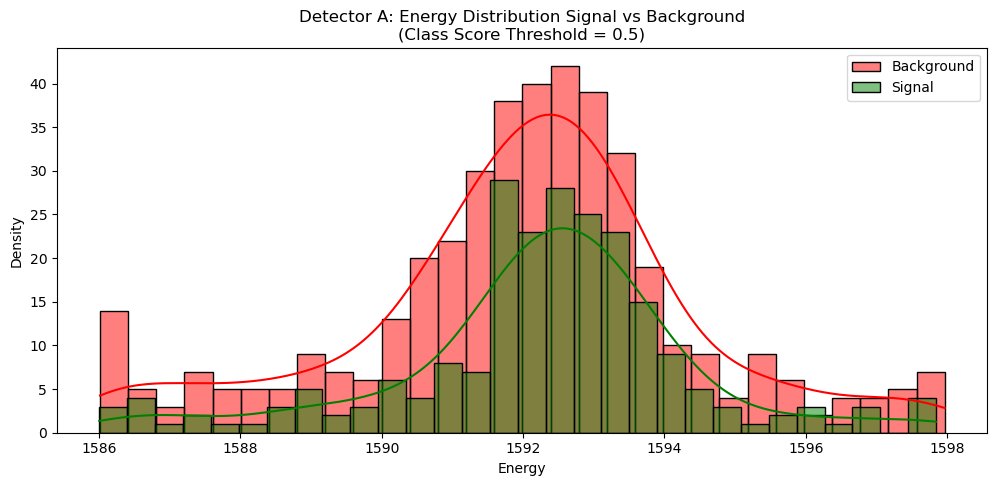

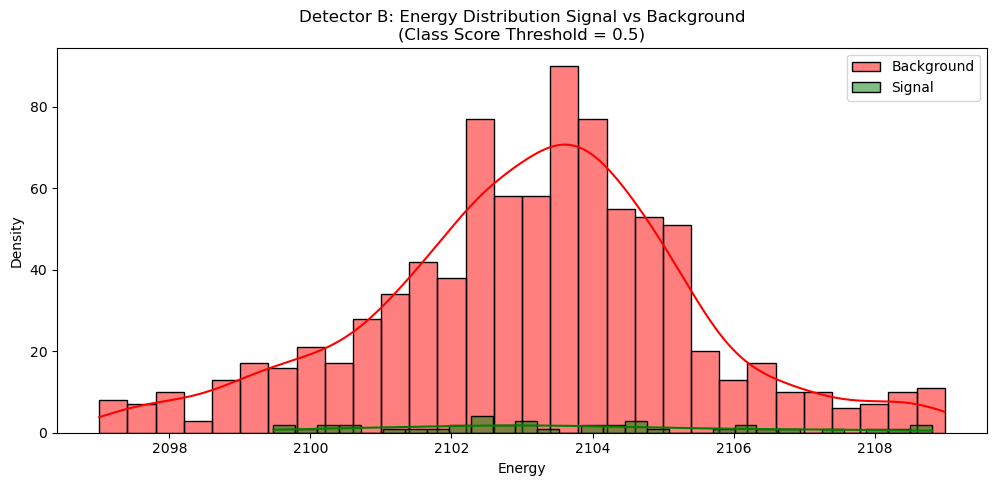

In [9]:
delta = 6
cA, cB, cC = [1592, 2103, 2039]
detA_select = (cA-delta, cA+delta, cA)
detB_select = (cB-delta, cB+delta, cB)
detC_select = (cC-delta, cC+delta, cC)

aReg = detA[(detA['energy'] > detA_select[0]) & (detA['energy'] < detA_select[1])]
bReg = detB[(detB['energy'] > detB_select[0]) & (detB['energy'] < detB_select[1])]
cReg = detC[(detC['energy'] > detC_select[0]) & (detC['energy'] < detC_select[1])]

aComp = detA[(detA['energy'] <= detA_select[0]) | (detA['energy'] >= detA_select[1])]
bComp = detB[(detB['energy'] <= detB_select[0]) | (detB['energy'] >= detB_select[1])]
cComp = detC[(detC['energy'] <= detC_select[0]) | (detC['energy'] >= detC_select[1])]

split_plot(aReg, 'Detector A', 0.5)
split_plot(bReg, 'Detector B', 0.5)

Best Threshold: 0.4900, TPR: 0.3690, FPR: 0.1465


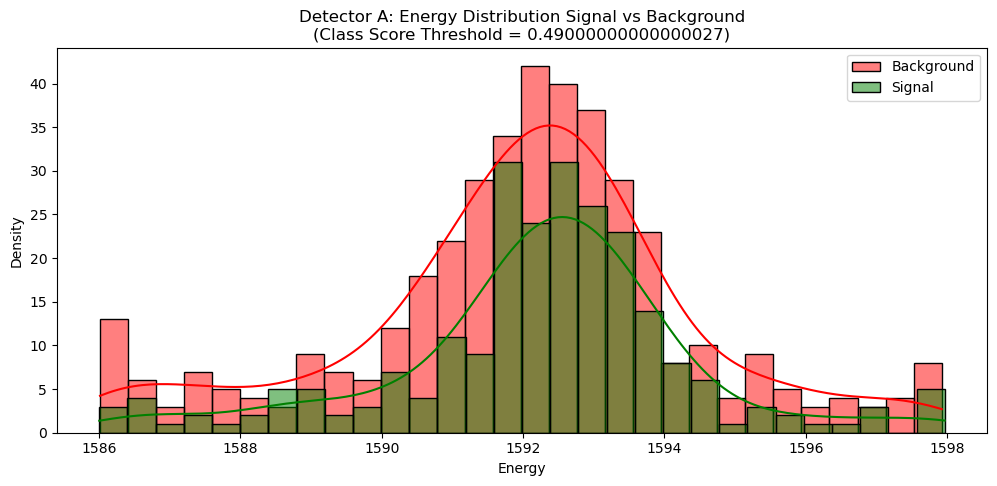

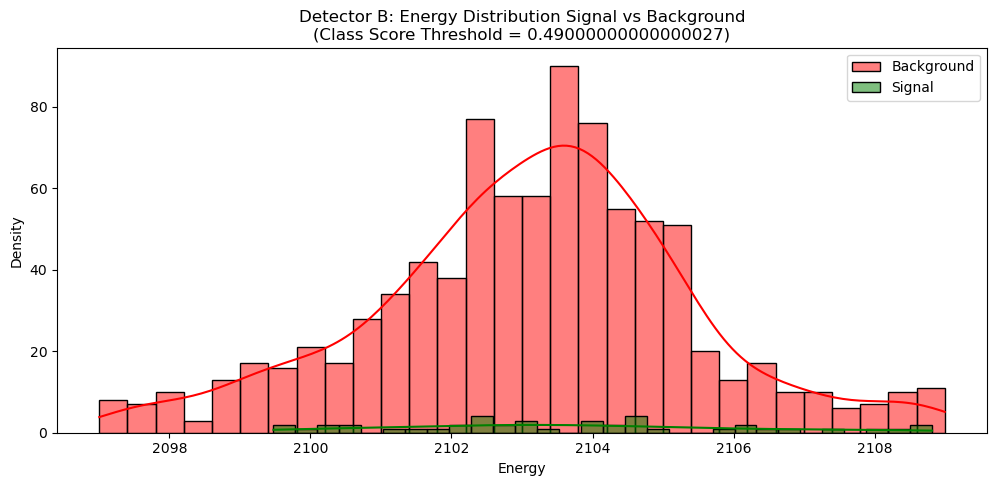

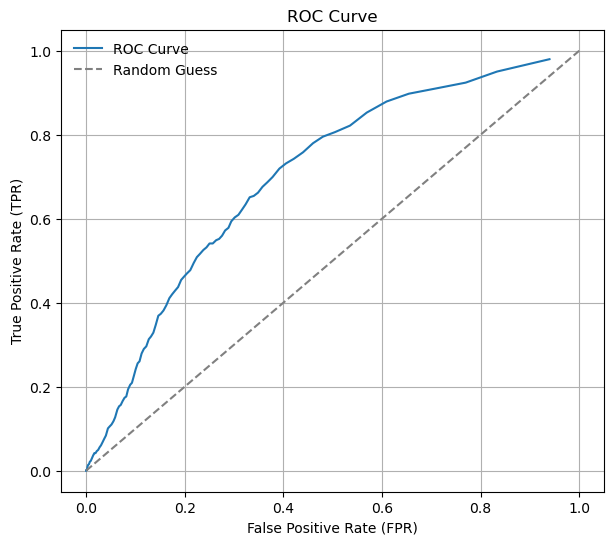

In [17]:
fpr = []
tpr = []
best_TPR = 0
best_FPR = 1
threshold = 0.0
best_threshold = 0.0
tp_fp_fn_bestThresh = (0,0,0)  

while threshold <= 1:
    # sigA is mostly true positives
    # sigB is mostly true negatives
    tp = aReg[aReg['class_score'] > threshold] # True Positives
    fn = aReg[aReg['class_score'] <= threshold] # False Negatives
    fp = aComp[aComp['class_score'] > threshold] # False Positives
    tn = aComp[aComp['class_score'] <= threshold] # True Negatives
    #Calc TPR, FPR and collect for ROC curve
    TPR = len(tp) / (len(tp) + len(fn))
    FPR = len(fp) / (len(fp) + len(tn))
    fpr.append(FPR)
    tpr.append(TPR)
    #Capture best values
    # Perhaps use F1 here? DONE: Implemented both. Both give the same best threshold
    #     # Commented f1_score implementation as it is more complex than needed
    #     # if required later, can uncomment. 
    #     #     # Also uncomment the 3 tp_fp_fn_bestThresh lines in the if retainer and initialization
    def f1_score(tp, fn, fp):
         precision = tp / (tp + fp) if (tp + fp) > 0 else 0
         recall = tp / (tp + fn) if (tp + fn) > 0 else 0
         if (precision + recall) == 0:
             return 0
         return 2 * (precision * recall) / (precision + recall)
    
    if f1_score(len(tp), len(fn), len(fp)) > f1_score(*tp_fp_fn_bestThresh):
    #if TPR - FPR > best_TPR - best_FPR: 
        best_TPR = TPR
        best_FPR = FPR
        best_threshold = threshold
        tp_fp_fn_bestThresh = (len(tp), len(fn), len(fp))  
         
    threshold += 0.01

print(f"Best Threshold: {best_threshold:.4f}, TPR: {best_TPR:.4f}, FPR: {best_FPR:.4f}")
split_plot(aReg, 'Detector A', best_threshold)
split_plot(bReg, 'Detector B', best_threshold)

# Plot ROC curve
plt.figure(figsize=(7, 6))
plt.plot(fpr, tpr, linestyle='-', label="ROC Curve")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label="Random Guess")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve")
plt.legend(frameon=False)
plt.grid()
plt.show()
    



# 4a Supply cuts to ABC

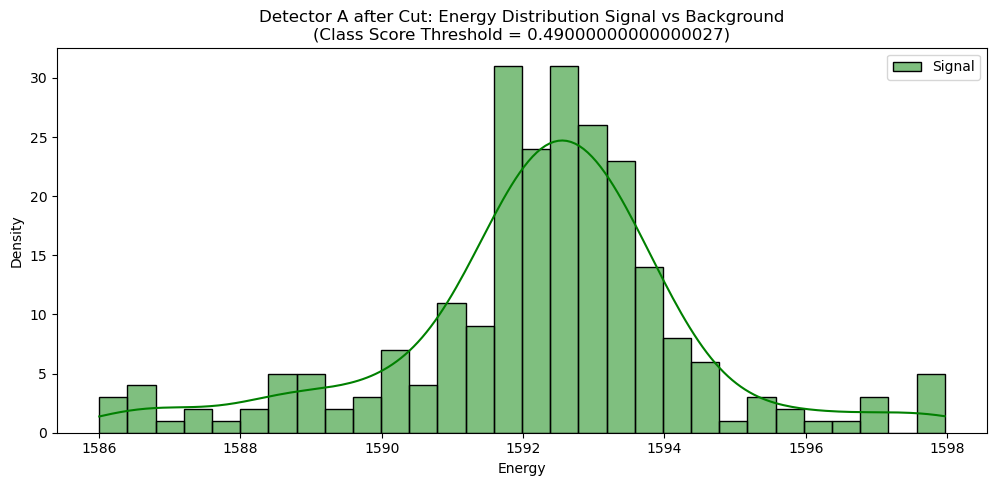

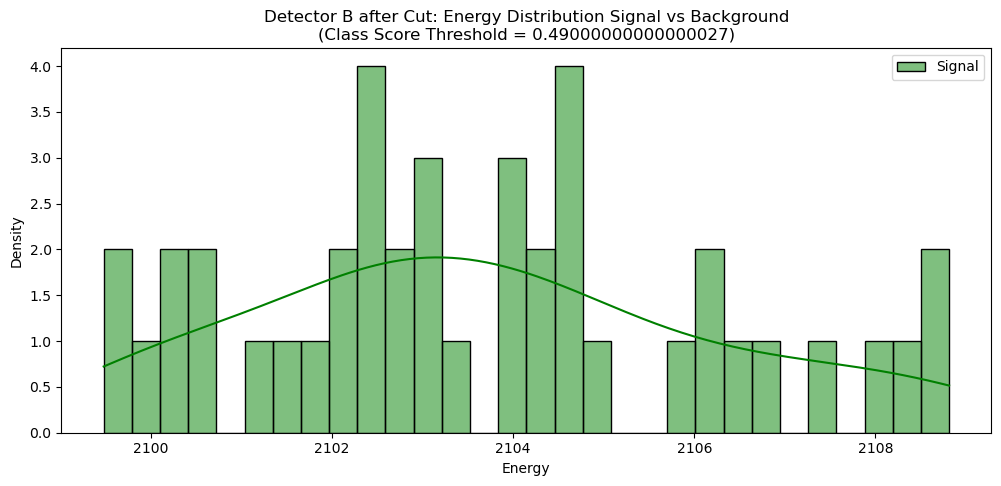

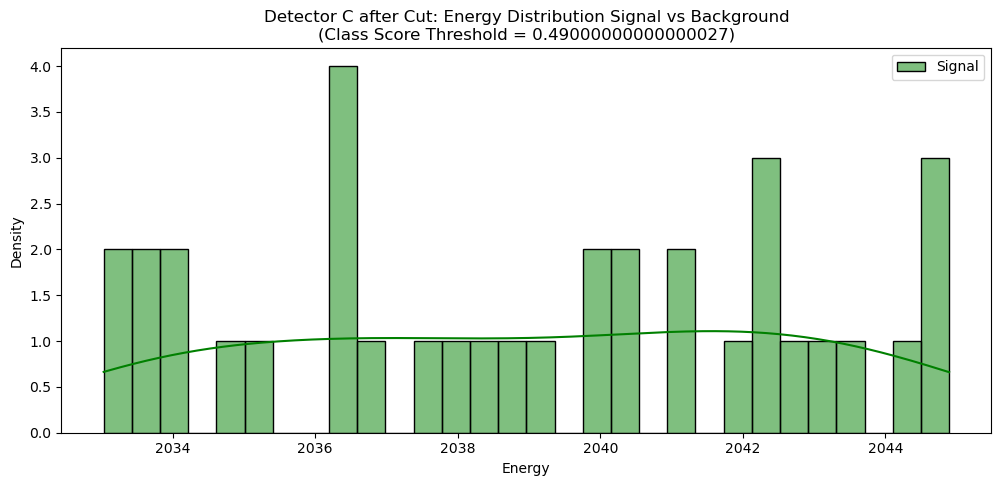

In [18]:
detAcut = aReg[aReg['class_score'] > best_threshold]
split_plot(detAcut, 'Detector A after Cut', best_threshold) 
detBcut = bReg[bReg['class_score'] > best_threshold]
split_plot(detBcut, 'Detector B after Cut', best_threshold) 
detCcut = cReg[cReg['class_score'] > best_threshold]
split_plot(detCcut, 'Detector C after Cut', best_threshold)

# 4b. Subtract baseline using linear + Gaussian model

In [35]:
def fit_signal_background(data, expected_center, E_min, E_max, n_bins=30):
    reg_select = data[(data['energy'] > E_min) & (data['energy'] < E_max)]
    intervals, bins = pd.cut(reg_select['energy'], bins=n_bins, retbins=True)
    x_data = (bins[1:] + bins[:-1]) / 2
    bin_width = bins[1] - bins[0]
    y_data = intervals.value_counts().sort_index().values

    def fit_func(x_data, A, mu, sigma, a, b):
        bkg = a * x_data + b
        gauss_model = A * np.exp(-0.5 * ((x_data - mu) / sigma) ** 2)
        return bkg + gauss_model

    def chi2(A, mu, sigma, a, b):
        y_model = fit_func(x_data, A, mu, sigma, a, b)
        quad_diffs = (y_data - y_model) ** 2
        return np.sum(np.divide(quad_diffs, y_data, out=np.zeros_like(quad_diffs), where=y_data!=0))
    
    m = Minuit(chi2, A=np.max(y_data)/2, mu=expected_center, sigma=2, a=0, b=0)
    m.limits['sigma'] = (0, None)
    m.migrad()
    A_fit, mu_fit, sigma_fit, a_fit, b_fit = m.values['A','mu','sigma','a','b']
    print('A_fit:', A_fit, 'mu_fit:', mu_fit, 'sigma_fit:', sigma_fit)
    print('a_fit:', a_fit, 'b_fit:', b_fit)
    bkgfit_y = a_fit * x_data + b_fit
    modelfit_y = A_fit * np.exp(-0.5 * ((x_data - mu_fit) / sigma_fit) ** 2)
    total_model_y = bkgfit_y + modelfit_y

    # Plot signal, backgound, and measured
    plt.plot(x_data, total_model_y, label = 'Total model')
    plt.plot(x_data, modelfit_y,'-.', label = 'Signal Model')
    plt.plot(x_data, bkgfit_y, label = 'Background Model')
    plt.scatter(x_data, y_data, color='black', label = 'Measured Histogram')
    plt.xlabel('Invariant Mass (GeV)')
    plt.ylabel('Counts per bin')
    plt.title('Modelling')
    plt.legend()
    plt.show()
    
    return x_data, bin_width, y_data - bkgfit_y



A_fit: 86.12215124956998 mu_fit: 1592.3946814921069 sigma_fit: 0.9976767324875189
a_fit: 0.06107019618477608 b_fit: -87.9120911732626


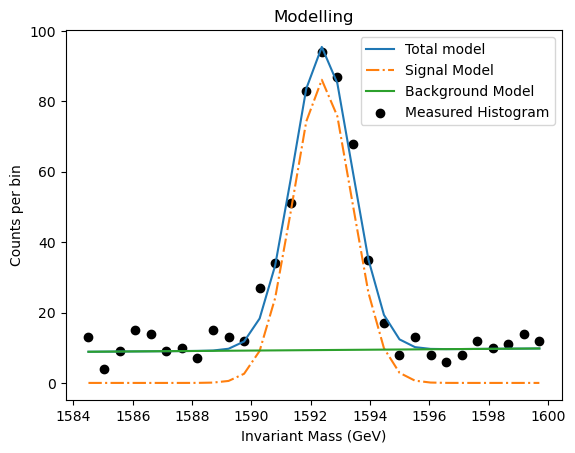

In [36]:
# Testing on Detector A without cut
bin_centersA, bin_widthA, rmvd_bkgA = fit_signal_background(detA, 1592, 1584, 1600, n_bins=30)

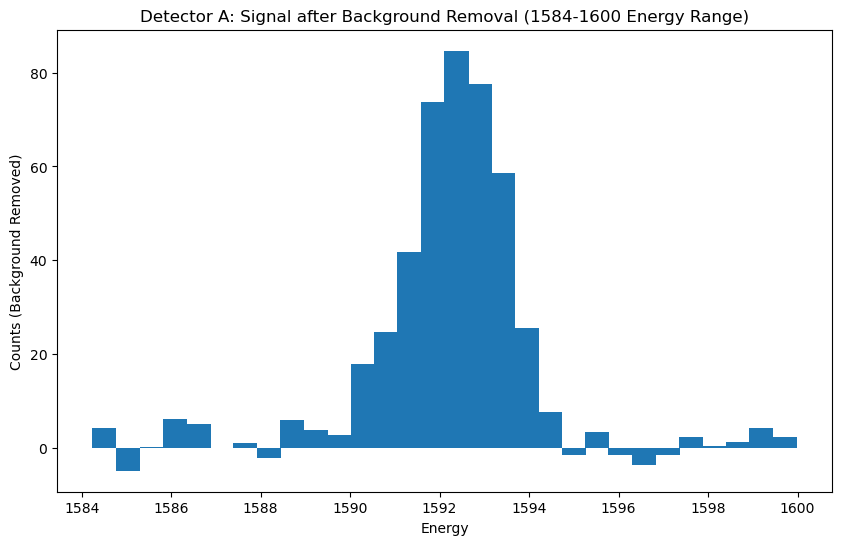

In [37]:
# Testing on Detector A without cut
plt.figure(figsize=(10,6))
plt.bar(bin_centersA, rmvd_bkgA, width=bin_widthA)
plt.xlabel('Energy')
plt.ylabel('Counts (Background Removed)')
plt.title('Detector A: Signal after Background Removal (1584-1600 Energy Range)')
plt.show()

Processing Detector A
Expected Center: 1592, Energy Range: 1586-1598
A_fit: 28.25078324361992 mu_fit: 1592.587237473991 sigma_fit: 0.9045015473919843
a_fit: -0.05434494112649651 b_fit: 88.3341539759481


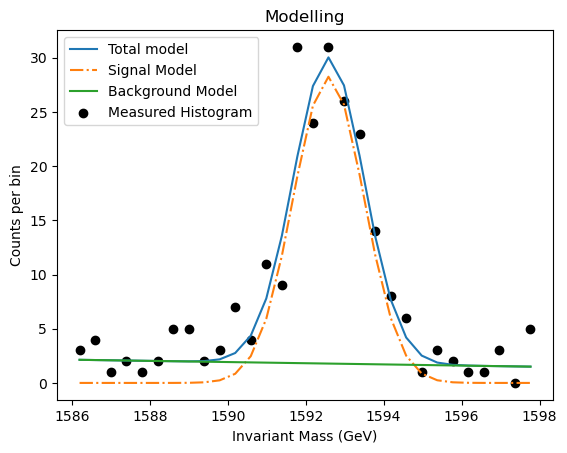

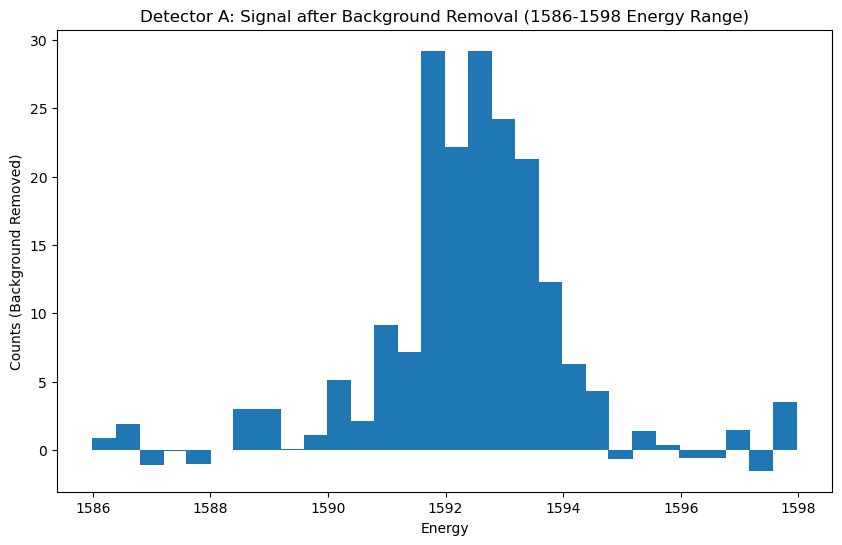

Processing Detector B
Expected Center: 2103, Energy Range: 2097-2109
A_fit: 0.832410693583322 mu_fit: 2103.6691143544313 sigma_fit: 1.0250651086737772
a_fit: -0.032051025360081746 b_fit: 68.65800513900324


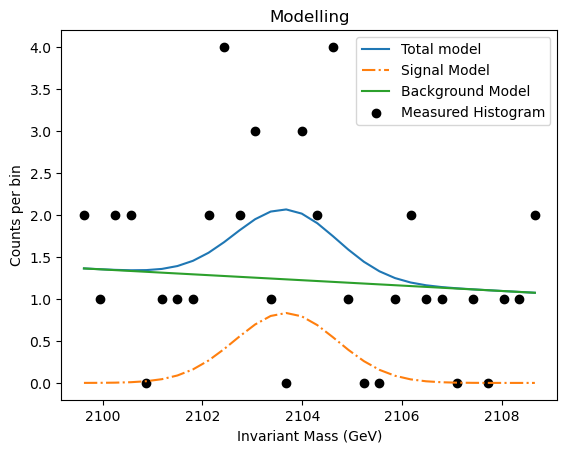

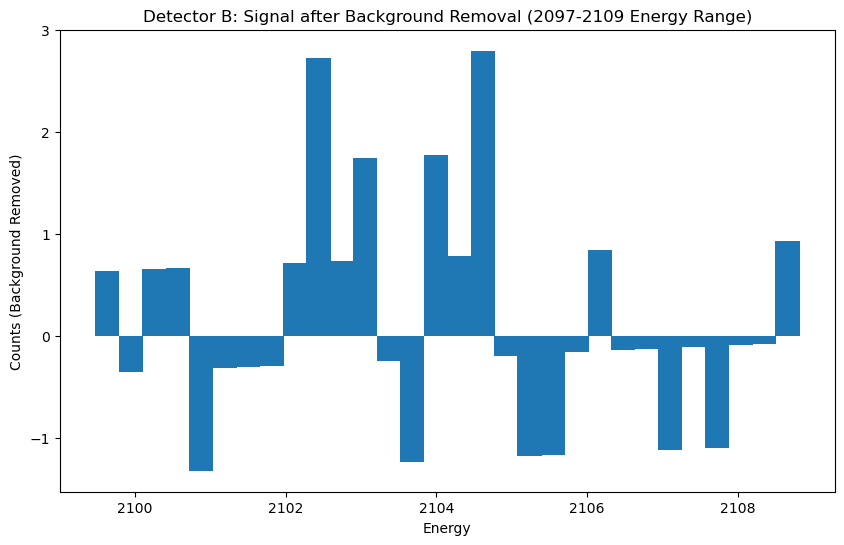

Processing Detector C
Expected Center: 2039, Energy Range: 2033-2045
A_fit: -38.665275038375064 mu_fit: 2040.0441532283387 sigma_fit: 37.92836345322234
a_fit: 0.00950872614245267 b_fit: 20.414569721430976


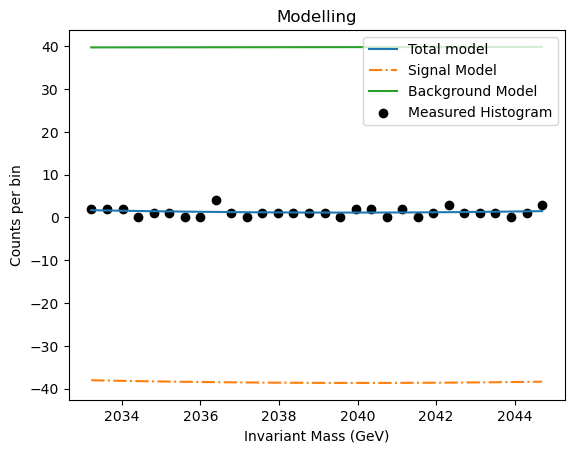

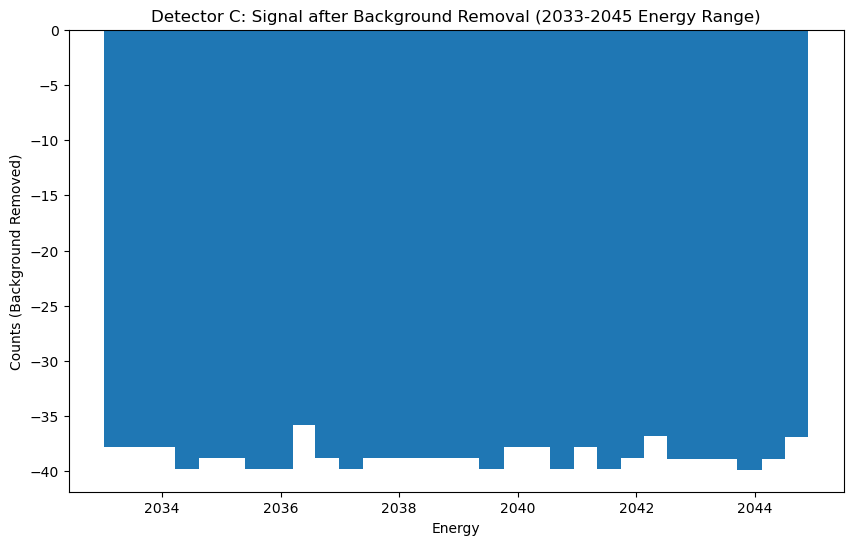

In [38]:
for (label, det, limits) in [('A', detAcut, detA_select), ('B', detBcut, detB_select), ('C', detCcut, detC_select)]:
    print(f"Processing Detector {label}")
    print(f"Expected Center: {limits[2]}, Energy Range: {limits[0]}-{limits[1]}")
    bin_centers, bin_width, rmvd_bkg = fit_signal_background(det, limits[2], limits[0], limits[1], n_bins=30)
    plt.figure(figsize=(10,6))
    plt.bar(bin_centers, rmvd_bkg, width=bin_width)
    plt.xlabel('Energy')
    plt.ylabel('Counts (Background Removed)')
    plt.title(f'Detector {label}: Signal after Background Removal ({limits[0]}-{limits[1]} Energy Range)')
    plt.show()